In [1]:
#import scvi
import torch
import os
import re
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

import skbio
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
from scipy.spatial.distance import squareform
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_

### Retrospective Power analysis

In [2]:
adata = sc.read_h5ad('/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 192149 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obsm['X_multivi'].shape, adata.obs['timepoint_type'].unique()

((192149, 23),
 ['preSCT', 'Relapse', 'MRD', 'Unknown']
 Categories (4, object): ['MRD', 'Relapse', 'Unknown', 'preSCT'])

For the task of preSCT prognostic value

In [5]:
# subset to only the timepoint_type == 'preSCT'
adata_preSCT = adata[adata.obs['timepoint_type'] == 'preSCT'].copy()
adata_preSCT.obsm['X_multivi'].shape

(64803, 23)

In [6]:
adata_preSCT.obs['sample'].unique()

['P01_preSCT', 'P01_preSCT_2', 'P02_preSCT_2', 'P02_preSCT_1', 'P04_preSCT_2', ..., 'P09_preSCT_2', 'P09_preSCT_1', 'P12_preSCT', 'P13_preSCT_1', 'P13_preSCT_2']
Length: 19
Categories (19, object): ['P01_preSCT', 'P01_preSCT_2', 'P02_preSCT_1', 'P02_preSCT_2', ..., 'P11_preSCT', 'P12_preSCT', 'P13_preSCT_1', 'P13_preSCT_2']

In [7]:
latent_df = pd.DataFrame(
    adata_preSCT.obsm['X_multivi'],
    columns=[f'LatentFactor_{i+1}' for i in range(23)]
)
latent_df['sample'] = adata_preSCT.obs['sample'].values

# Group by sample and calculate the mean for each latent factor
# This creates your (19, 23) matrix
summary_matrix = latent_df.groupby('sample').mean()

print("Shape of the summary matrix:", summary_matrix.shape)

Shape of the summary matrix: (19, 23)


/tmp/ipykernel_1008760/4097406666.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_matrix = latent_df.groupby('sample').mean()


In [8]:
sample_to_patient_map = adata_preSCT.obs[['sample', 'patient']].drop_duplicates().set_index('sample')

# Add the 'patient' column to our summary matrix
summary_matrix_with_patient = summary_matrix.join(sample_to_patient_map)

In [9]:
summary_matrix_with_patient

LatentFactor_1  LatentFactor_2  LatentFactor_3  LatentFactor_4  \
sample                                                                         
P01_preSCT          0.073891        0.097969        0.003263        0.066375   
P01_preSCT_2        0.071559        0.085012        0.009791        0.057931   
P02_preSCT_1        0.081224        0.109464       -0.050393        0.082619   
P02_preSCT_2        0.061358        0.128369       -0.029731        0.087833   
P04_preSCT_1        0.108766        0.099917       -0.051092        0.085665   
P04_preSCT_2        0.105129        0.106784       -0.051373        0.090438   
P05_preSCT          0.090676        0.087101       -0.093400        0.088569   
P06_preSCT_1        0.012759        0.141032        0.018274        0.049287   
P06_preSCT_2       -0.005286        0.164742        0.026225        0.039071   
P07_preSCT_2        0.045015        0.119797       -0.042379        0.083452   
P08_preSCT_1        0.054902        0.120341       -0.072413        0.067798   
P08_preSCT_2        0.056620        0.101713       -0.047756        0.081024   
P09_preSCT_1        0.085400        0.098077       -0.008575        0.085909   
P09_preSCT_2        0.078364        0.105215       -0.002752        0.077283   
P10_preSCT          0.087828        0.106007       -0.024134        0.087899   
P11_preSCT          0.093723        0.107860       -0.010016        0.077697   
P12_preSCT          0.081156        0.115674       -0.024845        0.071164   
P13_preSCT_1        0.063630        0.090530        0.006694        0.078245   
P13_preSCT_2        0.077247        0.093776       -0.003767        0.073972   

              LatentFactor_5  LatentFactor_6  LatentFactor_7  LatentFactor_8  \
sample                                                                         
P01_preSCT         -0.021078        0.050965        0.075661        0.001696   
P01_preSCT_2       -0.022090        0.055459        0.094140       -0.006828   
P02_preSCT_1       -0.040154        0.078271        0.027305        0.004612   
P02_preSCT_2       -0.051791        0.072574        0.045867        0.013954   
P04_preSCT_1       -0.038052        0.128929        0.009859       -0.019100   
P04_preSCT_2       -0.050428        0.114779        0.022313       -0.009300   
P05_preSCT         -0.025980        0.067372        0.109025        0.000952   
P06_preSCT_1       -0.063495        0.023179        0.081206       -0.010447   
P06_preSCT_2       -0.045588        0.058169        0.079793       -0.034542   
P07_preSCT_2       -0.013541        0.046929        0.089831        0.024995   
P08_preSCT_1       -0.079042        0.056258        0.021474       -0.028287   
P08_preSCT_2       -0.055044        0.027701        0.077234       -0.002149   
P09_preSCT_1        0.000054        0.058609        0.092165        0.021387   
P09_preSCT_2        0.000018        0.077325        0.076939        0.007146   
P10_preSCT         -0.019640        0.053212        0.052188        0.022639   
P11_preSCT         -0.021731        0.088951        0.039847        0.024799   
P12_preSCT         -0.028801        0.067122        0.037720        0.008742   
P13_preSCT_1       -0.026509        0.045844        0.095800        0.002120   
P13_preSCT_2       -0.025158        0.053115        0.079032       -0.002768   

              LatentFactor_9  LatentFactor_10  ...  LatentFactor_15  \
sample                                         ...                    
P01_preSCT         -0.088123        -0.007730  ...         0.017808   
P01_preSCT_2       -0.075919        -0.003947  ...         0.016665   
P02_preSCT_1       -0.111551        -0.016990  ...         0.030865   
P02_preSCT_2       -0.097716        -0.014037  ...         0.008358   
P04_preSCT_1       -0.084619        -0.012670  ...        -0.019324   
P04_preSCT_2       -0.085469        -0.012580  ...        -0.015688   
P05_preSCT         -0.079656        -0.004143  ...        -0.032239   
P06_preSCT_1 

In [10]:
icc_scores = []
# Loop through each of the 23 latent factors to calculate its ICC
for factor_col in [f'LatentFactor_{i+1}' for i in range(23)]:
    # The LMM formula: we are modeling the variation of the factor's value
    # The 'groups' argument specifies the clustering variable (patient)
    model = smf.mixedlm(f"{factor_col} ~ 1", data=summary_matrix_with_patient, groups="patient")
    
    try:
        results = model.fit()
        
        # Extract variance components
        # var_between (variance of random intercepts) is in results.cov_re
        var_between = results.cov_re.iloc[0,0]
        # var_within (residual variance) is in results.scale
        var_within = results.scale
        
        # Calculate ICC for this factor
        icc = var_between / (var_between + var_within)
        icc_scores.append(icc)
        
    except np.linalg.LinAlgError:
        print(f"Could not fit model for {factor_col}, skipping.")
        continue

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/hom

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/hom

In [ ]:
print(len(icc_scores))
print(icc_scores)

23


[0.9108117702512729,
 0.7105887709255801,
 0.915232593597736,
 0.8165772565000665,
 0.7967118999542593,
 0.7137580042477885,
 0.6541873257123217,
 0.5797885838875064,
 0.7360163196366972,
 0.8305056945456721,
 0.4120829612690492,
 0.8604096024144284,
 0.8459083097755773,
 0.732057988764783,
 0.9337073883026501,
 0.7127120136488678,
 0.7970644432908803,
 0.8328480928951205,
 0.7170913108166626,
 0.8164008222820812,
 0.8060345377444718,
 0.8791877437590446,
 0.8239386628416645]

In [12]:
# Calculate the average ICC across all well-behaved latent factors
average_icc_rho = np.mean(icc_scores)

print(f"\nCalculation Complete.")
print(f"The average Intra-Class Correlation (ICC, rho) is: {average_icc_rho:.4f}")


Calculation Complete.
The average Intra-Class Correlation (ICC, rho) is: 0.7754


In [13]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [14]:
responder_map = {
    'P10': 'Responder', 'P11': 'Responder', 'P12': 'Responder',
    'P09': 'Non-Responder', 'P13': 'Non-Responder', 'P04': 'Non-Responder',
    'P05': 'Non-Responder', 'P06': 'Non-Responder', 'P07': 'Non-Responder',
    'P08': 'Non-Responder', 'P02': 'Non-Responder', 'P01': 'Non-Responder'
}

In [15]:
summary_matrix_with_patient

LatentFactor_1  LatentFactor_2  LatentFactor_3  LatentFactor_4  \
sample                                                                         
P01_preSCT          0.073891        0.097969        0.003263        0.066375   
P01_preSCT_2        0.071559        0.085012        0.009791        0.057931   
P02_preSCT_1        0.081224        0.109464       -0.050393        0.082619   
P02_preSCT_2        0.061358        0.128369       -0.029731        0.087833   
P04_preSCT_1        0.108766        0.099917       -0.051092        0.085665   
P04_preSCT_2        0.105129        0.106784       -0.051373        0.090438   
P05_preSCT          0.090676        0.087101       -0.093400        0.088569   
P06_preSCT_1        0.012759        0.141032        0.018274        0.049287   
P06_preSCT_2       -0.005286        0.164742        0.026225        0.039071   
P07_preSCT_2        0.045015        0.119797       -0.042379        0.083452   
P08_preSCT_1        0.054902        0.120341       -0.072413        0.067798   
P08_preSCT_2        0.056620        0.101713       -0.047756        0.081024   
P09_preSCT_1        0.085400        0.098077       -0.008575        0.085909   
P09_preSCT_2        0.078364        0.105215       -0.002752        0.077283   
P10_preSCT          0.087828        0.106007       -0.024134        0.087899   
P11_preSCT          0.093723        0.107860       -0.010016        0.077697   
P12_preSCT          0.081156        0.115674       -0.024845        0.071164   
P13_preSCT_1        0.063630        0.090530        0.006694        0.078245   
P13_preSCT_2        0.077247        0.093776       -0.003767        0.073972   

              LatentFactor_5  LatentFactor_6  LatentFactor_7  LatentFactor_8  \
sample                                                                         
P01_preSCT         -0.021078        0.050965        0.075661        0.001696   
P01_preSCT_2       -0.022090        0.055459        0.094140       -0.006828   
P02_preSCT_1       -0.040154        0.078271        0.027305        0.004612   
P02_preSCT_2       -0.051791        0.072574        0.045867        0.013954   
P04_preSCT_1       -0.038052        0.128929        0.009859       -0.019100   
P04_preSCT_2       -0.050428        0.114779        0.022313       -0.009300   
P05_preSCT         -0.025980        0.067372        0.109025        0.000952   
P06_preSCT_1       -0.063495        0.023179        0.081206       -0.010447   
P06_preSCT_2       -0.045588        0.058169        0.079793       -0.034542   
P07_preSCT_2       -0.013541        0.046929        0.089831        0.024995   
P08_preSCT_1       -0.079042        0.056258        0.021474       -0.028287   
P08_preSCT_2       -0.055044        0.027701        0.077234       -0.002149   
P09_preSCT_1        0.000054        0.058609        0.092165        0.021387   
P09_preSCT_2        0.000018        0.077325        0.076939        0.007146   
P10_preSCT         -0.019640        0.053212        0.052188        0.022639   
P11_preSCT         -0.021731        0.088951        0.039847        0.024799   
P12_preSCT         -0.028801        0.067122        0.037720        0.008742   
P13_preSCT_1       -0.026509        0.045844        0.095800        0.002120   
P13_preSCT_2       -0.025158        0.053115        0.079032       -0.002768   

              LatentFactor_9  LatentFactor_10  ...  LatentFactor_15  \
sample                                         ...                    
P01_preSCT         -0.088123        -0.007730  ...         0.017808   
P01_preSCT_2       -0.075919        -0.003947  ...         0.016665   
P02_preSCT_1       -0.111551        -0.016990  ...         0.030865   
P02_preSCT_2       -0.097716        -0.014037  ...         0.008358   
P04_preSCT_1       -0.084619        -0.012670  ...        -0.019324   
P04_preSCT_2       -0.085469        -0.012580  ...        -0.015688   
P05_preSCT         -0.079656        -0.004143  ...        -0.032239   
P06_preSCT_1 

In [16]:
summary_matrix_with_patient['status'] = summary_matrix_with_patient['patient'].map(responder_map)


In [17]:
summary_matrix_with_patient

LatentFactor_1  LatentFactor_2  LatentFactor_3  LatentFactor_4  \
sample                                                                         
P01_preSCT          0.073891        0.097969        0.003263        0.066375   
P01_preSCT_2        0.071559        0.085012        0.009791        0.057931   
P02_preSCT_1        0.081224        0.109464       -0.050393        0.082619   
P02_preSCT_2        0.061358        0.128369       -0.029731        0.087833   
P04_preSCT_1        0.108766        0.099917       -0.051092        0.085665   
P04_preSCT_2        0.105129        0.106784       -0.051373        0.090438   
P05_preSCT          0.090676        0.087101       -0.093400        0.088569   
P06_preSCT_1        0.012759        0.141032        0.018274        0.049287   
P06_preSCT_2       -0.005286        0.164742        0.026225        0.039071   
P07_preSCT_2        0.045015        0.119797       -0.042379        0.083452   
P08_preSCT_1        0.054902        0.120341       -0.072413        0.067798   
P08_preSCT_2        0.056620        0.101713       -0.047756        0.081024   
P09_preSCT_1        0.085400        0.098077       -0.008575        0.085909   
P09_preSCT_2        0.078364        0.105215       -0.002752        0.077283   
P10_preSCT          0.087828        0.106007       -0.024134        0.087899   
P11_preSCT          0.093723        0.107860       -0.010016        0.077697   
P12_preSCT          0.081156        0.115674       -0.024845        0.071164   
P13_preSCT_1        0.063630        0.090530        0.006694        0.078245   
P13_preSCT_2        0.077247        0.093776       -0.003767        0.073972   

              LatentFactor_5  LatentFactor_6  LatentFactor_7  LatentFactor_8  \
sample                                                                         
P01_preSCT         -0.021078        0.050965        0.075661        0.001696   
P01_preSCT_2       -0.022090        0.055459        0.094140       -0.006828   
P02_preSCT_1       -0.040154        0.078271        0.027305        0.004612   
P02_preSCT_2       -0.051791        0.072574        0.045867        0.013954   
P04_preSCT_1       -0.038052        0.128929        0.009859       -0.019100   
P04_preSCT_2       -0.050428        0.114779        0.022313       -0.009300   
P05_preSCT         -0.025980        0.067372        0.109025        0.000952   
P06_preSCT_1       -0.063495        0.023179        0.081206       -0.010447   
P06_preSCT_2       -0.045588        0.058169        0.079793       -0.034542   
P07_preSCT_2       -0.013541        0.046929        0.089831        0.024995   
P08_preSCT_1       -0.079042        0.056258        0.021474       -0.028287   
P08_preSCT_2       -0.055044        0.027701        0.077234       -0.002149   
P09_preSCT_1        0.000054        0.058609        0.092165        0.021387   
P09_preSCT_2        0.000018        0.077325        0.076939        0.007146   
P10_preSCT         -0.019640        0.053212        0.052188        0.022639   
P11_preSCT         -0.021731        0.088951        0.039847        0.024799   
P12_preSCT         -0.028801        0.067122        0.037720        0.008742   
P13_preSCT_1       -0.026509        0.045844        0.095800        0.002120   
P13_preSCT_2       -0.025158        0.053115        0.079032       -0.002768   

              LatentFactor_9  LatentFactor_10  ...  LatentFactor_16  \
sample                                         ...                    
P01_preSCT         -0.088123        -0.007730  ...        -0.061830   
P01_preSCT_2       -0.075919        -0.003947  ...        -0.058844   
P02_preSCT_1       -0.111551        -0.016990  ...        -0.056821   
P02_preSCT_2       -0.097716        -0.014037  ...        -0.048021   
P04_preSCT_1       -0.084619        -0.012670  ...        -0.014328   
P04_preSCT_2       -0.085469        -0.012580  ...        -0.016502   
P05_preSCT         -0.079656        -0.004143  ...        -0.053130   
P06_preSCT_1 

In [18]:
patient_feature_matrix = summary_matrix_with_patient.groupby('patient').mean(numeric_only=True)

/tmp/ipykernel_1008760/1929176953.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_feature_matrix = summary_matrix_with_patient.groupby('patient').mean(numeric_only=True)


In [19]:
patient_feature_matrix

LatentFactor_1  LatentFactor_2  LatentFactor_3  LatentFactor_4  \
patient                                                                   
P01            0.072725        0.091490        0.006527        0.062153   
P02            0.071291        0.118917       -0.040062        0.085226   
P04            0.106947        0.103351       -0.051232        0.088051   
P05            0.090676        0.087101       -0.093400        0.088569   
P06            0.003737        0.152887        0.022249        0.044179   
P07            0.045015        0.119797       -0.042379        0.083452   
P08            0.055761        0.111027       -0.060085        0.074411   
P09            0.081882        0.101646       -0.005664        0.081596   
P10            0.087828        0.106007       -0.024134        0.087899   
P11            0.093723        0.107860       -0.010016        0.077697   
P12            0.081156        0.115674       -0.024845        0.071164   
P13            0.070439        0.092153        0.001464        0.076108   

         LatentFactor_5  LatentFactor_6  LatentFactor_7  LatentFactor_8  \
patient                                                                   
P01           -0.021584        0.053212        0.084901       -0.002566   
P02           -0.045972        0.075423        0.036586        0.009283   
P04           -0.044240        0.121854        0.016086       -0.014200   
P05           -0.025980        0.067372        0.109025        0.000952   
P06           -0.054542        0.040674        0.080499       -0.022494   
P07           -0.013541        0.046929        0.089831        0.024995   
P08           -0.067043        0.041980        0.049354       -0.015218   
P09            0.000036        0.067967        0.084552        0.014266   
P10           -0.019640        0.053212        0.052188        0.022639   
P11           -0.021731        0.088951        0.039847        0.024799   
P12           -0.028801        0.067122        0.037720        0.008742   
P13           -0.025834        0.049480        0.087416       -0.000324   

         LatentFactor_9  LatentFactor_10  ...  LatentFactor_14  \
patient                                   ...                    
P01           -0.082021        -0.005838  ...         0.018102   
P02           -0.104633        -0.015513  ...         0.007738   
P04           -0.085044        -0.012625  ...        -0.035785   
P05           -0.079656        -0.004143  ...         0.024798   
P06           -0.070438        -0.016992  ...         0.009193   
P07           -0.111995        -0.023728  ...         0.013260   
P08           -0.082785        -0.019423  ...        -0.034911   
P09           -0.101103        -0.005966  ...         0.002481   
P10           -0.118606        -0.026845  ...         0.023214   
P11           -0.104481        -0.010541  ...         0.016174   
P12           -0.103355        -0.014437  ...         0.002547   
P13           -0.094163        -0.009350  ...         0.003626   

         LatentFactor_15  LatentFactor_16  LatentFactor_17  LatentFactor_18  \
patient                                                                       
P01             0.017237        -0.060337         0.038537         0.112024   
P02             0.019611        -0.052421         0.024790         0.125385   
P04            -0.017506        -0.015415        -0.003653         0.074014   
P05            -0.032239        -0.053130         0.017747         0.128816   
P06            -0.036783        -0.024460         0.033674         0.156560   
P07            -0.022616        -0.063375         0.015111         0.121064   
P08            -0.076525        -0.003252         0.007803         0.118645   
P09             0.017099        -0.067943         0.020373         0.100037   
P10             0.002062        -0.063803         0.043413         0.117036   
P11             0.004205        -0.056946         0.024061         0.086229   
P12             0.015665        -0

In [22]:
# Get the corresponding labels for each patient
patient_labels = summary_matrix_with_patient.groupby('patient')['status'].first() 
patient_labels_binary = (patient_labels == 'Non-Responder').astype(int)

# Ensure data is aligned
X_patient = patient_feature_matrix.loc[patient_labels_binary.index]
y_patient = patient_labels_binary

# It's good practice to scale features for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_patient)

# Setup the model and cross-validator
# Using L1 (Lasso) for feature selection. C is the inverse of regularization strength.
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.5, class_weight='balanced') 
loo = LeaveOneOut()

# Store predictions from LOOCV
y_true_loocv = []
y_pred_probs_loocv = []

for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_patient.iloc[train_index], y_patient.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    # Predict probability for the positive class (Non-Responder)
    pred_prob = model.predict_proba(X_test)[:, 1]
    
    y_true_loocv.append(y_test.iloc[0])
    y_pred_probs_loocv.append(pred_prob[0])

# Calculate the single AUROC score from all LOOCV predictions
auroc_pilot = roc_auc_score(y_true_loocv, y_pred_probs_loocv)
print(f"The Preliminary AUROC from LOOCV is: {auroc_pilot:.4f}")

# Now, calculate the Standard Error of this AUROC using bootstrapping on the predictions
n_bootstraps = 1000
bootstrapped_aurocs = []
for _ in range(n_bootstraps):
    # Sample with replacement from the prediction pairs
    indices = np.random.choice(len(y_true_loocv), size=len(y_true_loocv), replace=True)
    
    # Check if we have both classes in the bootstrap sample
    if len(np.unique(np.array(y_true_loocv)[indices])) < 2:
        continue # Skip bootstrap sample if it only contains one class
        
    resampled_auroc = roc_auc_score(np.array(y_true_loocv)[indices], np.array(y_pred_probs_loocv)[indices])
    bootstrapped_aurocs.append(resampled_auroc)

# The Standard Error is the standard deviation of the bootstrap distribution
se_auroc_pilot = np.std(bootstrapped_aurocs)
print(f"The Standard Error (SE) of the AUROC is: {se_auroc_pilot:.4f}")

# The 95% CI is approximately AUROC +/- 1.96 * SE
ci_lower = auroc_pilot - 1.96 * se_auroc_pilot
ci_upper = auroc_pilot + 1.96 * se_auroc_pilot
ci_half_width_pilot = 1.96 * se_auroc_pilot

print(f"The 95% CI for the AUROC is: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"The CI half-width is: +/- {ci_half_width_pilot:.4f}")

/tmp/ipykernel_1008760/782090804.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  patient_labels = summary_matrix_with_patient.groupby('patient')['status'].first()


The Preliminary AUROC from LOOCV is: 0.8519
The Standard Error (SE) of the AUROC is: 0.1145
The 95% CI for the AUROC is: [0.6274, 1.0763]
The CI half-width is: +/- 0.2244


Older Permanova stuff 

In [ ]:
# --- Subsampling ---
n_subsample = 60000 # Choose a manageable number of cells
if adata.n_obs > n_subsample:
    print(f"Subsampling to {n_subsample} cells...")
    adata_subsample = sc.pp.subsample(adata, n_obs=n_subsample, copy=True, random_state=42)
    print(f"Subsampled AnnData object created with shape: {adata_subsample.shape}")
else:
    print("Number of cells is already less than or equal to n_subsample. Using all cells.")
    adata_subsample = adata.copy()

Subsampling to 40000 cells...
Subsampled AnnData object created with shape: (40000, 36601)


In [11]:
adata.obs['Tech'].value_counts()

Tech
Multi    126320
CITE      65829
Name: count, dtype: int64

In [5]:
# --- Recalculate distances for the subsample ---
print("Extracting multiVI embeddings for the subsample...")
multiVI_embeddings_subsample = adata_subsample.obsm['X_multivi']

print("Calculating Euclidean distance matrix for the subsample...")
# Using float32 can help manage memory even for the subsample's distance matrix
if multiVI_embeddings_subsample.dtype != np.float32:
    print("Converting multiVI embeddings to float32 for memory efficiency...")
    multiVI_embeddings_subsample = multiVI_embeddings_subsample.astype(np.float32)

distance_array_full_subsample = euclidean_distances(multiVI_embeddings_subsample)
print(f"Shape of full distance array for subsample: {distance_array_full_subsample.shape}")

print("Converting to condensed distance matrix (1D form) for subsample...")
condensed_distance_array_subsample = squareform(distance_array_full_subsample, force='tovector', checks=False)
print(f"Shape of condensed distance array for subsample: {condensed_distance_array_subsample.shape}")
print(f"Memory of condensed array for subsample: ~{condensed_distance_array_subsample.nbytes / (1024**2):.2f} MB")

del distance_array_full_subsample # Clean up the larger square matrix for the subsample
gc.collect()

# --- Create skbio.DistanceMatrix for the subsample ---
print("Creating skbio.DistanceMatrix object from subsample's condensed form...")
cell_ids_subsample = adata_subsample.obs_names.tolist()

try:
    skbio_distance_matrix_subsample = skbio.stats.distance.DistanceMatrix(
        condensed_distance_array_subsample,
        ids=cell_ids_subsample
    )
    print("skbio.DistanceMatrix object for subsample created successfully.")

    # --- Run PERMANOVA on the subsample ---
    print("Running PERMANOVA on the subsample for batch effect assessment...")
    grouping_variable_batch_subsample = adata_subsample.obs['batch']

    permanova_results_batch_subsample = skbio.stats.distance.permanova(
        skbio_distance_matrix_subsample,
        grouping_variable_batch_subsample,
        permutations=999 # You could try fewer permutations if still struggling, e.g., 199 or 499
    )
    print("\nPERMANOVA results for batch effect (subsample):")
    print(permanova_results_batch_subsample)

except MemoryError:
    print("MemoryError: Still ran out of memory even with the subsample.")
    print("Try reducing n_subsample further or check other processes consuming RAM.")
except Exception as e:
    print(f"An error occurred with the subsample: {e}")

Extracting multiVI embeddings for the subsample...
Calculating Euclidean distance matrix for the subsample...
Shape of full distance array for subsample: (40000, 40000)
Converting to condensed distance matrix (1D form) for subsample...
Shape of condensed distance array for subsample: (799980000,)
Memory of condensed array for subsample: ~3051.68 MB
Creating skbio.DistanceMatrix object from subsample's condensed form...
skbio.DistanceMatrix object for subsample created successfully.
Running PERMANOVA on the subsample for batch effect assessment...

PERMANOVA results for batch effect (subsample):
method name                PERMANOVA
test statistic name         pseudo-F
sample size                    40000
number of groups                  21
test statistic            197.624495
p-value                        0.001
number of permutations           999
Name: PERMANOVA results, dtype: object


PERMANOVA on full data matrix

In [2]:
output_adata_corrected_rna_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad'

batch_corrected_rna_adata = sc.read_h5ad(output_adata_corrected_rna_path) # takes 2 mins 50s

In [3]:
batch_corrected_rna_adata

AnnData object with n_obs × n_vars = 192149 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

Do PERMANOVA test for batch correction

In [4]:
print("Extracting multiVI embeddings...")
multiVI_embeddings = batch_corrected_rna_adata.obsm['X_multivi']

print("Calculating Euclidean distance matrix...")
distance_array = euclidean_distances(multiVI_embeddings)
print(f"Shape of distance array: {distance_array.shape}")

Extracting multiVI embeddings...
Calculating Euclidean distance matrix...
Shape of distance array: (192149, 192149)


In [9]:
print("Converting to condensed distance matrix (1D form)...")
# This takes the upper triangle of the distance_array_full
condensed_distance_array = squareform(distance_array, force='tovector', checks=False)
print(f"Shape of condensed distance array: {condensed_distance_array.shape}")
print(f"Memory of condensed array: ~{condensed_distance_array.nbytes / (1024**3):.2f} GB")

# At this point, you can delete the full distance array to free up memory
del distance_array

Converting to condensed distance matrix (1D form)...
Shape of condensed distance array: (18460523026,)
Memory of condensed array: ~68.77 GB


In [10]:
import gc
gc.collect() # Trigger garbage collection
print("Full distance array deleted.")

Full distance array deleted.


In [11]:
print("Creating skbio.DistanceMatrix object...")
# Ensure your adata.obs_names are unique and suitable as IDs
cell_ids = batch_corrected_rna_adata.obs_names.tolist()
try:
    # Pass the 1D condensed array directly
    skbio_distance_matrix = skbio.stats.distance.DistanceMatrix(condensed_distance_array, ids=cell_ids)
    print("skbio.DistanceMatrix object created successfully from condensed form.")

    # Now you can proceed with PERMANOVA
    print("Running PERMANOVA for batch effect assessment...")
    grouping_variable_batch = batch_corrected_rna_adata.obs['batch']
    
    permanova_results_batch = skbio.stats.distance.permanova(
        skbio_distance_matrix,
        grouping_variable_batch,
        permutations=999
    )
    print("\nPERMANOVA results for batch effect:")
    print(permanova_results_batch)

except MemoryError:
    print("MemoryError: Still ran out of memory creating skbio.DistanceMatrix or during PERMANOVA.")
    print("The skbio.DistanceMatrix object itself might be too large, or PERMANOVA is memory-intensive.")
    print("Consider subsampling your cells if this persists.")
except Exception as e:
    print(f"An error occurred: {e}")

Creating skbio.DistanceMatrix object...
skbio.DistanceMatrix object created successfully from condensed form.
Running PERMANOVA for batch effect assessment...


: 

In [ ]:
# --- 3. Run PERMANOVA test for batch effects ---
print("Running PERMANOVA for batch effect assessment...")
grouping_variable_batch = batch_corrected_rna_adata.obs['batch']

# Ensure the order of cells in grouping_variable_batch matches skbio_distance_matrix.ids
# If adata.obs_names was used for ids, and grouping_variable_batch is adata.obs['batch'],
# they should inherently be in the same order.
# For safety, you can reorder grouping_variable_batch if necessary:
# sorted_cell_ids = skbio_distance_matrix.ids
# grouping_variable_batch_sorted = adata.obs.loc[sorted_cell_ids, 'batch']

try:
    permanova_results_batch = skbio.stats.distance.permanova(
        skbio_distance_matrix,
        grouping_variable_batch,
        permutations=999  # Use a reasonable number of permutations
    )
    print("\nPERMANOVA results for batch effect:")
    print(permanova_results_batch)
    # For good batch correction, you hope for a non-significant p-value here.
except Exception as e:
    print(f"An error occurred during PERMANOVA: {e}")
    print("This could be due to issues with group sizes or the distance matrix.")

Running PERMANOVA for batch effect assessment...


In [ ]:
# --- 4. Generate boxplot of within- V.S. between- batch distances ---
print("\nGenerating boxplot for within- vs. between-batch distances...")

# This part can also be computationally intensive for the full matrix.
# Consider if sampling is appropriate for visualization if it's too slow.

# Get batch labels
batches = batch_corrected_rna_adata.obs['batch'].values
n_cells = distance_array.shape[0]
within_batch_distances = []
between_batch_distances = []

# Iterate over the upper triangle of the distance matrix
for i in range(n_cells):
    for j in range(i + 1, n_cells):
        dist = distance_array[i, j]
        if batches[i] == batches[j]:
            within_batch_distances.append(dist)
        else:
            between_batch_distances.append(dist)

# Create a DataFrame for plotting
df_within = pd.DataFrame({'distance': within_batch_distances, 'type': 'Within-Batch'})
df_between = pd.DataFrame({'distance': between_batch_distances, 'type': 'Between-Batch'})
plot_df = pd.concat([df_within, df_between])

plt.figure(figsize=(8, 6))
sns.boxplot(x='type', y='distance', data=plot_df, palette="Set2")
plt.title('Comparison of Within-Batch and Between-Batch Distances (multiVI space)')
plt.ylabel('Euclidean Distance')
plt.xlabel('')
plt.tight_layout()
plt.show()
print("Boxplot generation complete.")

Add FDL embedding (40 mins) and then save the adata with embedding (20 mins) 

Now the loaded adata should have FDL embedding


In [ ]:
# add fdl embedding (takes 40 mins)
# sc.tl.draw_graph(batch_corrected_rna_adata, layout='fa', random_state=0)

In [ ]:
# save the adata now with the FDL embedding
#output_adata_corrected_rna_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad'

#batch_corrected_rna_adata.write_h5ad(output_adata_corrected_rna_path, compression='gzip', compression_opts=9)

Subsett for donor and recipient for plotting

In [19]:
plt.subplots_adjust(wspace=0.65, hspace=0.3)

<Figure size 640x480 with 0 Axes>

In [30]:
batch_corrected_rna_adata.obs['patient'].unique() # check the batch labels

['P01', 'P02', 'P03', 'P04', 'P05', ..., 'P08', 'P11', 'P09', 'P12', 'P13']
Length: 14
Categories (14, object): ['P01', 'P02', 'P03', 'P04', ..., 'P11', 'P12', 'P13', 'unknown']

In [7]:
# subset for only the donor cells
batch_corrected_rna_adata_donor = batch_corrected_rna_adata[batch_corrected_rna_adata.obs['source'] == 'donor'].copy()

In [ ]:
batch_corrected_rna_adata_donor

AnnData object with n_obs × n_vars = 71450 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [8]:
# subset for only the recipient cells
batch_corrected_rna_adata_recipient = batch_corrected_rna_adata[batch_corrected_rna_adata.obs['source'] == 'recipient'].copy()

In [9]:
timepoint_colors = {'preSCT': 'green', 'MRD': 'red', 'Relapse': 'blue'}
color_features_to_plot = ['patient', 'predicted.annotation', 'predicted.pseudotime', 'timepoint_type']

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


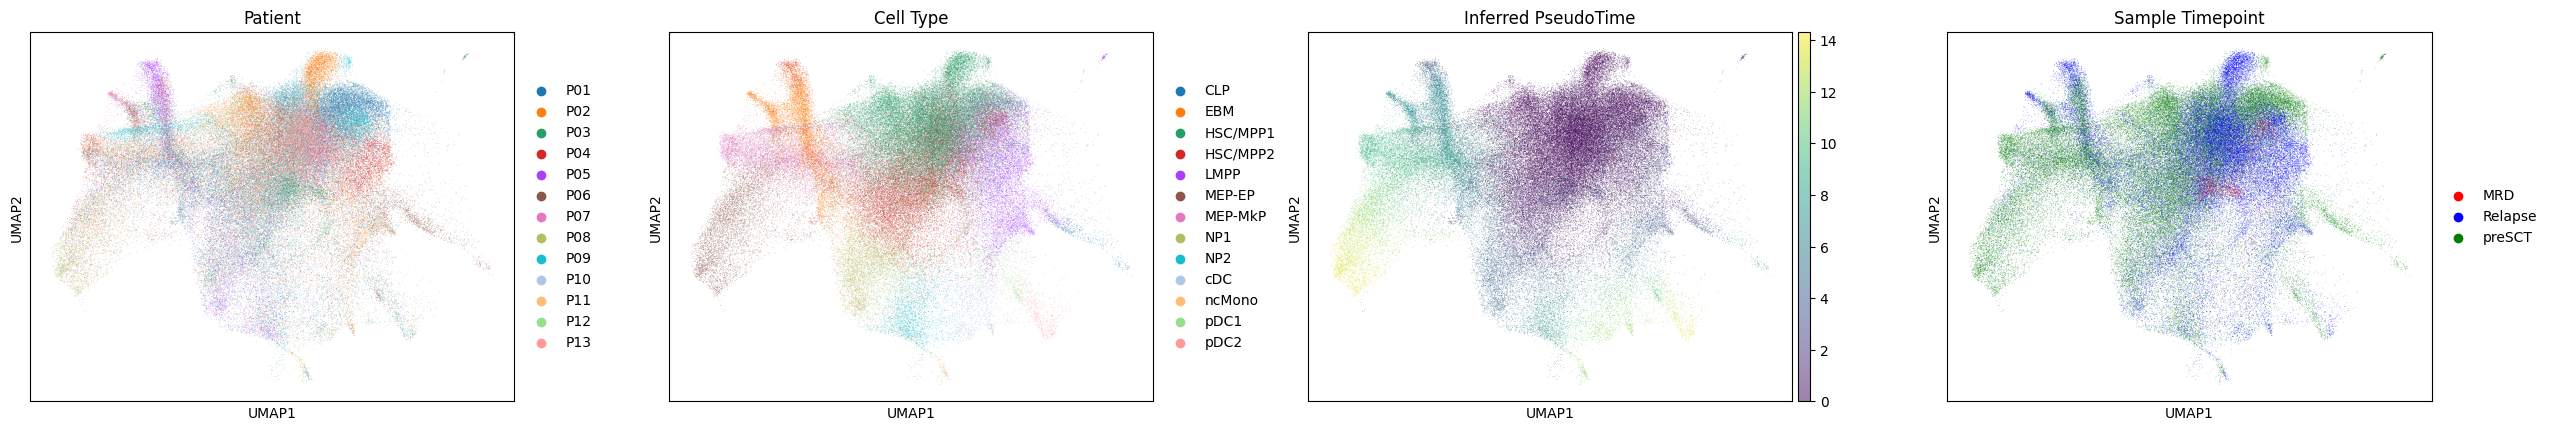

In [23]:
# Your defined colors
timepoint_colors_dict = {'preSCT': 'green', 'MRD': 'red', 'Relapse': 'blue'}
color_features_to_plot = ['patient', 'predicted.annotation', 'predicted.pseudotime', 'timepoint_type']
titles_for_plot = ['Patient', 'Cell Type', "Inferred PseudoTime", "Sample Timepoint"]

# 1. Ensure 'timepoint_type' is categorical and get its categories
if batch_corrected_rna_adata_recipient.obs['timepoint_type'].dtype.name != 'category':
    batch_corrected_rna_adata_recipient.obs['timepoint_type'] = pd.Categorical(batch_corrected_rna_adata_recipient.obs['timepoint_type'])

current_categories = batch_corrected_rna_adata_recipient.obs['timepoint_type'].cat.categories

# 2. Create an ordered list of colors based on the AnnData's category order
# Important: Ensure all categories in your data are keys in your timepoint_colors_dict
# and that the casing matches.
ordered_timepoint_colors = []
missing_categories = []
for cat in current_categories:
    color = timepoint_colors_dict.get(cat)
    if color is None:
        # Handle categories in data not present in your color map
        missing_categories.append(cat)
        ordered_timepoint_colors.append('#CCCCCC') # Default to grey for missing
    else:
        ordered_timepoint_colors.append(color)

if missing_categories:
    print(f"Warning: The following categories in 'timepoint_type' were not found in your timepoint_colors_dict and will be colored grey: {missing_categories}")
    print(f"Your color dictionary keys: {list(timepoint_colors_dict.keys())}")
    print(f"Categories in data: {list(current_categories)}")


# 3. Store this ordered color list in adata.uns
# Scanpy looks for '{category_obs_key}_colors' in adata.uns
batch_corrected_rna_adata_recipient.uns['timepoint_type_colors'] = ordered_timepoint_colors

# 4. Now, plot WITHOUT the palette argument for timepoint_type.
# Scanpy will automatically use batch_corrected_rna_adata_recipient.uns['timepoint_type_colors']
# For other features, it will use their respective .uns entries if they exist, or internal defaults.
sc.pl.umap(
    batch_corrected_rna_adata_recipient,
    color=color_features_to_plot,
    title=titles_for_plot, # Use your custom titles
    show=True, 
    wspace=0.2,
    alpha=0.5
)

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


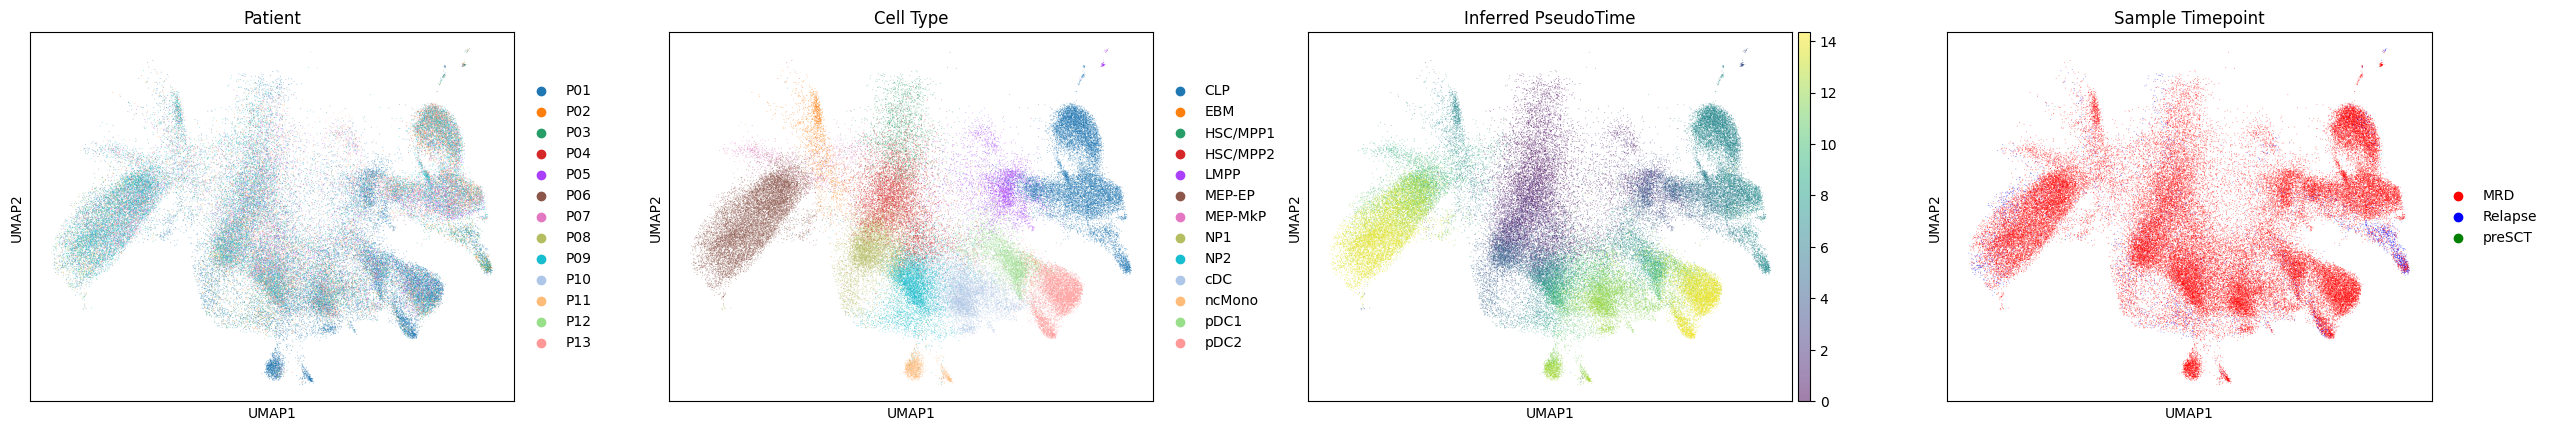

In [24]:
# Your defined colors
timepoint_colors_dict = {'preSCT': 'green', 'MRD': 'red', 'Relapse': 'blue'}
color_features_to_plot = ['patient', 'predicted.annotation', 'predicted.pseudotime', 'timepoint_type']
titles_for_plot = ['Patient', 'Cell Type', "Inferred PseudoTime", "Sample Timepoint"]

# 1. Ensure 'timepoint_type' is categorical and get its categories
if batch_corrected_rna_adata_donor.obs['timepoint_type'].dtype.name != 'category':
    batch_corrected_rna_adata_donor.obs['timepoint_type'] = pd.Categorical(batch_corrected_rna_adata_recipient.obs['timepoint_type'])

current_categories = batch_corrected_rna_adata_donor.obs['timepoint_type'].cat.categories

# 2. Create an ordered list of colors based on the AnnData's category order
# Important: Ensure all categories in your data are keys in your timepoint_colors_dict
# and that the casing matches.
ordered_timepoint_colors = []
missing_categories = []
for cat in current_categories:
    color = timepoint_colors_dict.get(cat)
    if color is None:
        # Handle categories in data not present in your color map
        missing_categories.append(cat)
        ordered_timepoint_colors.append('#CCCCCC') # Default to grey for missing
    else:
        ordered_timepoint_colors.append(color)

if missing_categories:
    print(f"Warning: The following categories in 'timepoint_type' were not found in your timepoint_colors_dict and will be colored grey: {missing_categories}")
    print(f"Your color dictionary keys: {list(timepoint_colors_dict.keys())}")
    print(f"Categories in data: {list(current_categories)}")


# 3. Store this ordered color list in adata.uns
# Scanpy looks for '{category_obs_key}_colors' in adata.uns
batch_corrected_rna_adata_donor.uns['timepoint_type_colors'] = ordered_timepoint_colors

# 4. Now, plot WITHOUT the palette argument for timepoint_type.
# Scanpy will automatically use batch_corrected_rna_adata_donor.uns['timepoint_type_colors']
# For other features, it will use their respective .uns entries if they exist, or internal defaults.
sc.pl.umap(
    batch_corrected_rna_adata_donor,
    color=color_features_to_plot,
    title=titles_for_plot, # Use your custom titles
    show=True,
    wspace=0.2,
    alpha=0.5
)

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


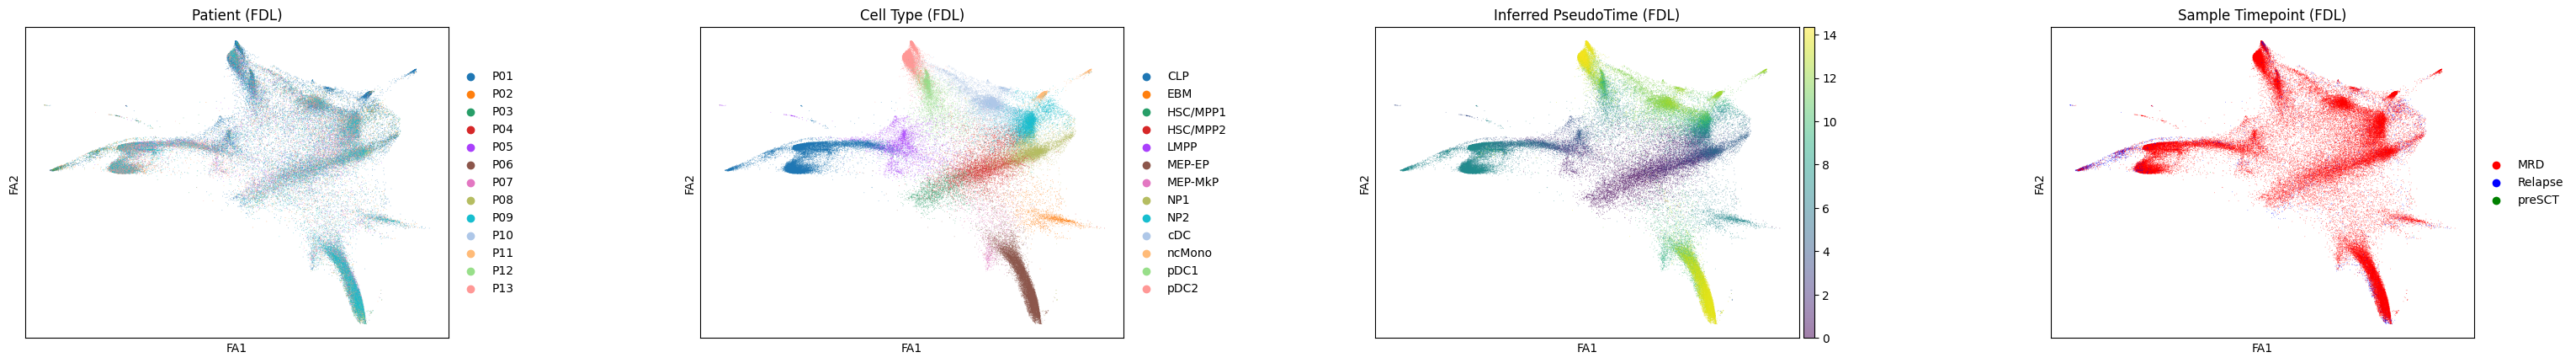

In [29]:
sc.pl.draw_graph(
    batch_corrected_rna_adata_donor,
    layout="fa",                       # tells Scanpy to use X_draw_graph_fa
    color=color_features_to_plot,
    title=[f"{t} (FDL)" for t in titles_for_plot],
    alpha=0.5,
    wspace=0.45, hspace=0.35,          # enlarge the gaps between panels
    legend_loc="right margin",         # keeps legends inside each panel’s margin
    show=True
)

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


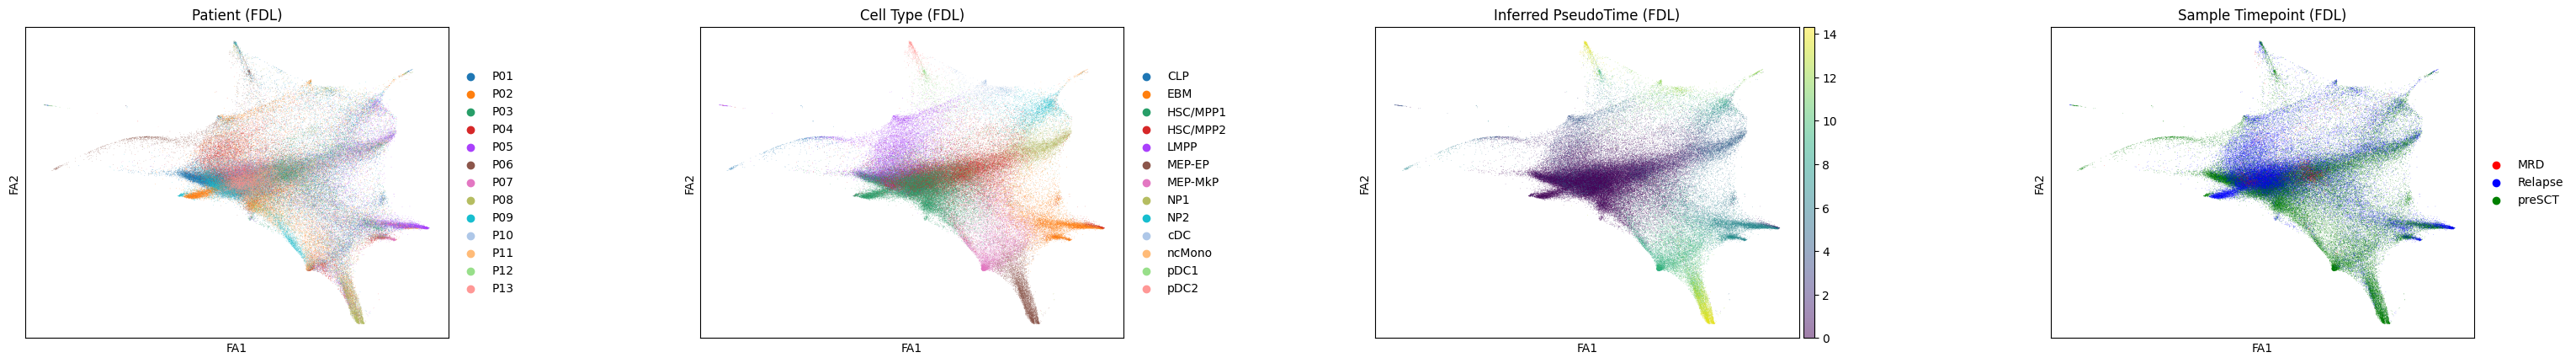

In [28]:
sc.pl.draw_graph(
    batch_corrected_rna_adata_recipient,
    layout="fa",                       # tells Scanpy to use X_draw_graph_fa
    color=color_features_to_plot,
    title=[f"{t} (FDL)" for t in titles_for_plot],
    alpha=0.5,
    wspace=0.45, hspace=0.35,          # enlarge the gaps between panels
    legend_loc="right margin",         # keeps legends inside each panel’s margin
    show=True
)

Subset to draw P02 over its samples in timepoint order

In [31]:
P02_adata = batch_corrected_rna_adata[batch_corrected_rna_adata.obs['patient'] == "P02"].copy()


In [32]:
P02_adata.obs['sample'].unique() # check the batch labels

['P02_Relapse_2', 'P02_preSCT_2', 'P02_Relapse_1', 'P02_MRD_1', 'P02_preSCT_1', 'P02_Relapse_4', 'P02_Relapse_3', 'P02_MRD_2']
Categories (8, object): ['P02_MRD_1', 'P02_MRD_2', 'P02_Relapse_1', 'P02_Relapse_2', 'P02_Relapse_3', 'P02_Relapse_4', 'P02_preSCT_1', 'P02_preSCT_2']

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

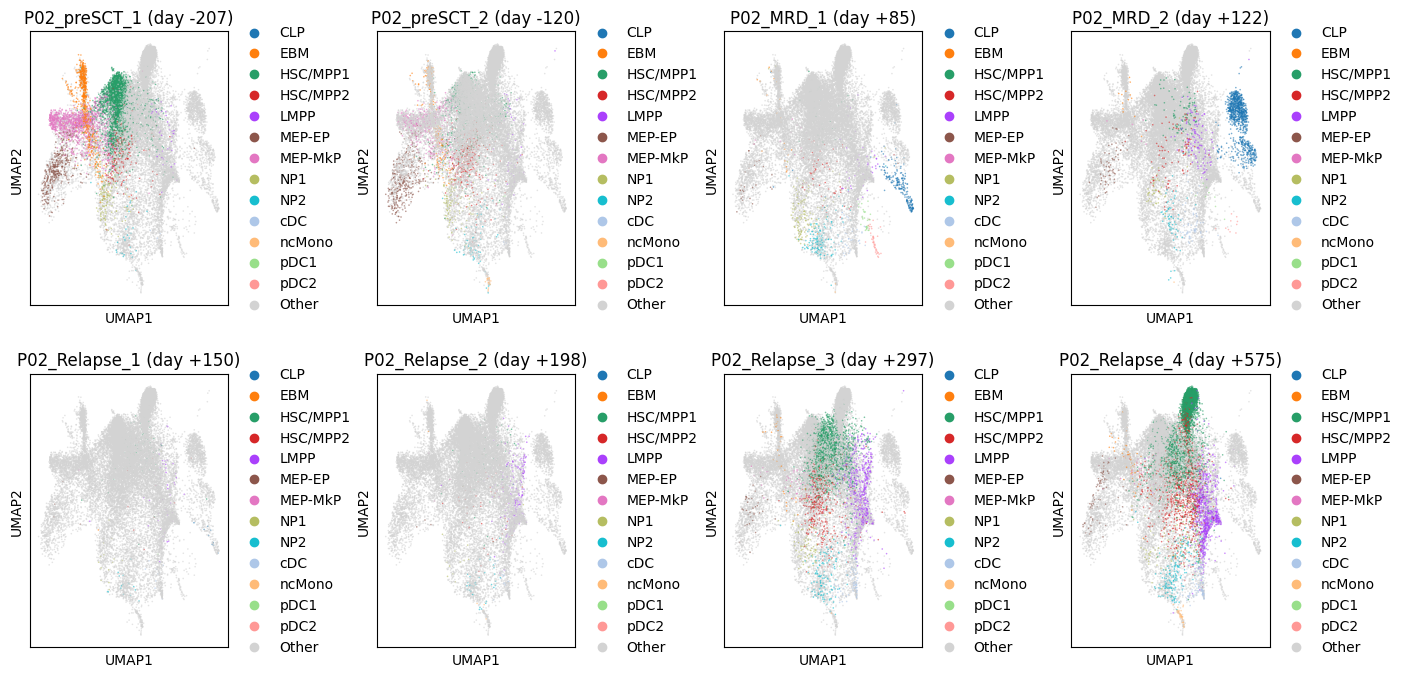

In [ ]:
sample_order = [
    'P02_preSCT_1', 'P02_preSCT_2',
    'P02_MRD_1',    'P02_MRD_2',
    'P02_Relapse_1','P02_Relapse_2',
    'P02_Relapse_3','P02_Relapse_4'
]

sample_days_relative_to_SCT = [
    '-207', '-120', '+85', '+122', '+150', '+198', '+297', '+575'
]
P02_adata.obs['sample'] = pd.Categorical(
    P02_adata.obs['sample'],
    categories=sample_order,
    ordered=True
)

# ------------------------------------------------------------------
# 2)  PREP PALETTE: keep Scanpy’s colours for cell‑types, add grey
# ------------------------------------------------------------------
cell_types   = list(P02_adata.obs['predicted.annotation'].cat.categories)
cell_palette = dict(
    zip(cell_types, P02_adata.uns['predicted.annotation_colors'])
)
cell_palette['Other'] = '#D3D3D3'          # light grey for non‑sample cells

# ------------------------------------------------------------------
# 3)  2 × 4 GRID   (all cells plotted each time)
# ------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=4,
    figsize=(16, 8),
    constrained_layout=False
)

for i, sample in enumerate(sample_order):
    if sample not in P02_adata.obs['sample'].cat.categories:
        continue

    # make a temporary colour column: cell‑type for in‑sample, 'Other' otherwise
    highlight = np.where(
        P02_adata.obs['sample'] == sample,
        P02_adata.obs['predicted.annotation'].astype(str),
        'Other samples'
    )
    col_name = 'highlight_annotation'
    P02_adata.obs[col_name] = pd.Categorical(highlight, categories=cell_types + ['Other'])

    ax = axes[i // 4, i % 4]
    plot_title = sample.replace('P02_', '')   # drop the patient prefix for brevity
    plot_title = f'{sample} (day {sample_days_relative_to_SCT[i]})'
    sc.pl.umap(
        P02_adata,
        color=col_name,                    # **single** categorical → ax allowed
        palette=cell_palette,
        alpha=0.6,
        legend_loc='right margin',
        show=False,
        ax=ax,
        title=plot_title   # drop the patient prefix for brevity
    )

# tidy spacing so legends never collide
fig.subplots_adjust(wspace=0.75, hspace=0.25)
# fig.suptitle('Patient P02 – UMAPs   (in‑sample cells coloured, others grey)', fontsize=16, y=1.02)
plt.show()

/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

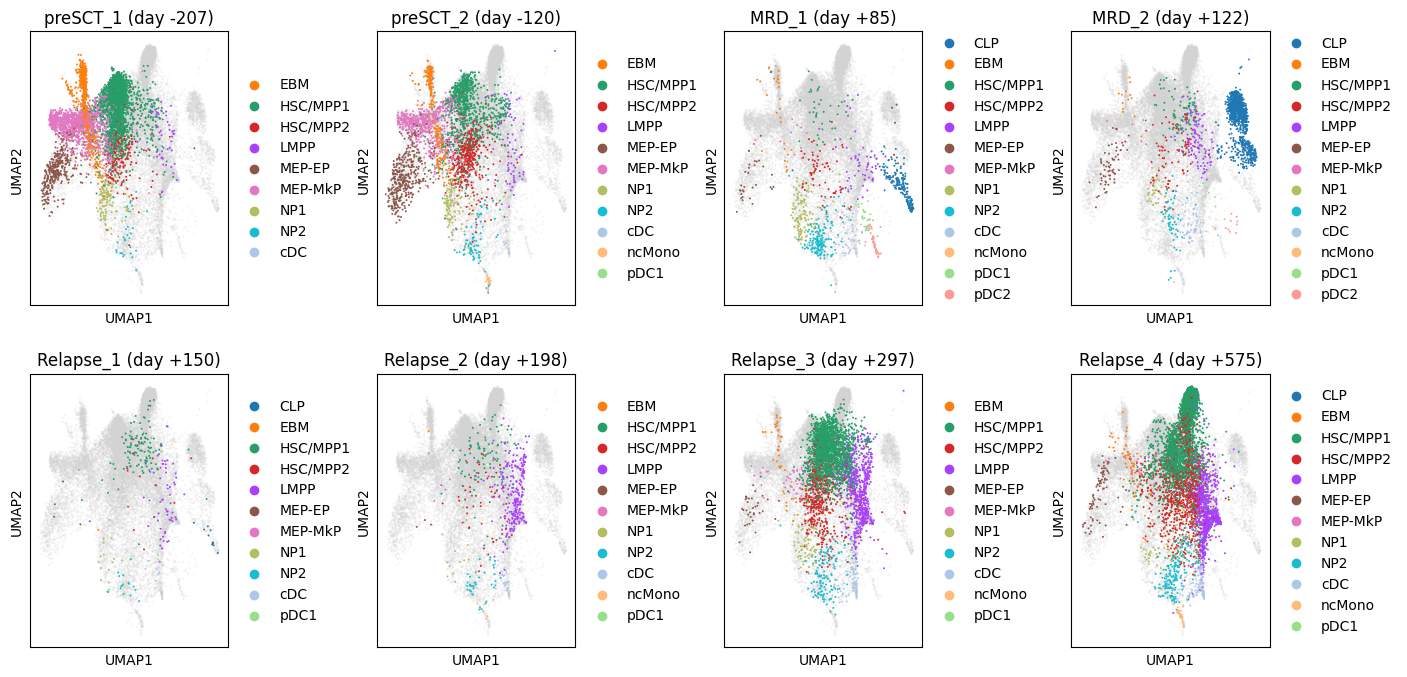

In [43]:
sample_order = [
    'P02_preSCT_1', 'P02_preSCT_2',
    'P02_MRD_1',    'P02_MRD_2',
    'P02_Relapse_1','P02_Relapse_2',
    'P02_Relapse_3','P02_Relapse_4'
]
sample_days_relative_to_SCT = [
    '-207', '-120', '+85', '+122', '+150', '+198', '+297', '+575'
]

P02_adata.obs['sample'] = pd.Categorical(
    P02_adata.obs['sample'],
    categories=sample_order,
    ordered=True
)

# ------------------------------------------------------------
# 1)  SET UP THE PALETTE (cell‑type colours + grey)
# ------------------------------------------------------------
cell_types     = list(P02_adata.obs['predicted.annotation'].cat.categories)
cell_palette   = dict(zip(cell_types, P02_adata.uns['predicted.annotation_colors']))
grey_color     = '#D3D3D3'       # background grey

# ------------------------------------------------------------
# 2)  BUILD THE 2 × 4 GRID
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), constrained_layout=False)

for i, sample in enumerate(sample_order):
    if sample not in P02_adata.obs['sample'].cat.categories:
        continue

    mask_cur   = P02_adata.obs['sample'] == sample
    mask_other = ~mask_cur

    ad_cur   = P02_adata[mask_cur].copy()
    ad_other = P02_adata[mask_other].copy()

    # --- dummy column so Scanpy can colour the background layer -------------
    ad_other.obs['bg'] = 'Other'            # constant category
    bg_palette         = {'Other': grey_color}

    ax = axes[i // 4, i % 4]

    # Layer 1: all OTHER‑sample cells, semi‑transparent grey
    sc.pl.umap(
        ad_other,
        color='bg',
        palette=bg_palette,
        alpha=0.25,                         # faint
        size=8,
        legend_loc=None,
        show=False,
        ax=ax
    )

    # Layer 2: CURRENT‑sample cells, full‑opacity, coloured by type
    sc.pl.umap(
        ad_cur,
        color='predicted.annotation',
        palette=cell_palette,
        alpha=1.0,                          # crisp highlight
        size=8,
        legend_loc='right margin',
        show=False,
        ax=ax,
        title=f"{sample.replace('P02_', '')} (day {sample_days_relative_to_SCT[i]})"
    )

# widen gaps so legends breathe
fig.subplots_adjust(wspace=0.75, hspace=0.25)
plt.show()

/tmp/ipykernel_490927/3286297382.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mrd_adata.obs['CN.label'] = pd.Categorical(mrd_adata.obs['CN.label'])
/home/minhang/miniconda3/envs/spectra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


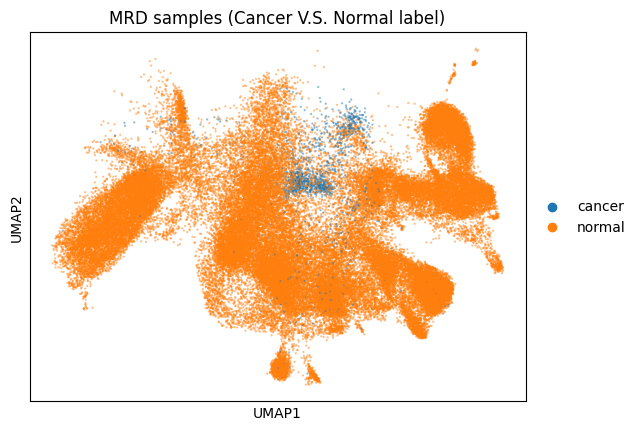

In [48]:
# ------------------------------------------------------------------
# 1)  Subset: timepoint_type == 'MRD'  AND  CN.label not‑null
# ------------------------------------------------------------------
mrd_adata = (
    batch_corrected_rna_adata
      .copy()[
          (batch_corrected_rna_adata.obs['timepoint_type'] == 'MRD')
          & batch_corrected_rna_adata.obs['CN.label'].notna()
      ]
)

# Make sure CN.label is categorical (helps with palette & legend ordering)
mrd_adata.obs['CN.label'] = pd.Categorical(mrd_adata.obs['CN.label'])

# ------------------------------------------------------------------
# 2)  Optional: give each CN.label a colour (otherwise Scanpy picks defaults)
#     If you already have a colour list, keep it; otherwise build one quickly.
# ------------------------------------------------------------------
if 'CN.label_colors' not in mrd_adata.uns:
    import seaborn as sns   # just for a quick distinct palette
    clrs = sns.color_palette('husl', len(mrd_adata.obs['CN.label'].cat.categories))
    mrd_adata.uns['CN.label_colors'] = [sns.utils.rgb2hex(c) for c in clrs]

# ------------------------------------------------------------------
# 3)  Plot UMAP
#     (Assumes the UMAP embedding already exists in .obsm['X_umap'];
#      if not, run sc.pp.neighbors / sc.tl.umap first.)
# ------------------------------------------------------------------
sc.pl.umap(
    mrd_adata,
    color='CN.label',
    legend_loc='right margin',
    frameon=True,
    alpha=0.5,      # tweak if you want translucency
    size=10,        # point size
    title='MRD samples (Cancer V.S. Normal label)'
)